### NYC taxi trip duration prediction - EDA and Feature Engineering

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

In [2]:
os.chdir('C:/Users/Bangda/Desktop/kaggle/ny-taxi')
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
train.shape, test.shape

((1458644, 11), (625134, 9))

In [4]:
# no missing data
all_data = [train, test]
for df in all_data:
    print(df.apply(lambda x: x.isnull().sum()))
    print("==================================")

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


In [5]:
# calculate skewness and kurtosis of trip_duration and log(trip_duration)
print("skewness of raw trip_duration: {}".format(skew(train['trip_duration'])))
print("kurtosis of raw trip_duration: {}".format(kurtosis(train['trip_duration'])))
print("skewness of log-trip_duration: {}".format(skew(np.log(train['trip_duration']))))
print("kurtosis of log-trip_duration: {}".format(kurtosis(np.log(train['trip_duration']))))

skewness of raw trip_duration: 343.163590698
kurtosis of raw trip_duration: 192130.858707
skewness of log-trip_duration: -0.340703880084
kurtosis of log-trip_duration: 4.1742557209


In [6]:
train['log_trip_duration'] = np.log(train['trip_duration'])
for df in all_data:
    df['pickup_longitude'] = np.abs(df['pickup_longitude'])
    df['dropoff_longitude'] = np.abs(df['dropoff_longitude'])

In [7]:
# calculate the distance between two location based on latitude and longitude
def deg2rad(degree):
    return degree * np.pi / 180.0

def get_distance(long_x, lat_x, long_y, lat_y):
    R = 6371.0
    dlong = deg2rad(long_y - long_x)
    dlat = deg2rad(lat_y - lat_x)
    a = np.sin(dlat / 2.) ** 2 + np.cos(deg2rad(lat_x)) * np.cos(deg2rad(lat_y)) * np.sin(dlong / 2.) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    return R * c

In [8]:
# take an example, match with the result from google calculator
get_distance(train.loc[0, 'pickup_longitude'], train.loc[0, 'pickup_latitude'], 
             train.loc[0, 'dropoff_longitude'], train.loc[0, 'dropoff_latitude'])

1.4985207796462985

In [9]:
# vectorize the calculation function
get_distance = np.vectorize(get_distance)
for df in all_data:
    df['direct_distance'] = get_distance(np.array(df['pickup_longitude']), 
                                         np.array(df['pickup_latitude']), 
                                         np.array(df['dropoff_longitude']), 
                                         np.array(df['dropoff_latitude']))

In [10]:
train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'direct_distance', 'log_trip_duration']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,direct_distance,log_trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,7.397349e+01,4.075092e+01,7.397342e+01,4.075180e+01,3.440864e+00,6.464521e+00
std,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,4.296538e+00,7.996122e-01
min,6.133553e+01,3.435970e+01,6.133553e+01,3.218114e+01,0.000000e+00,0.000000e+00
25%,7.396733e+01,4.073735e+01,7.396301e+01,4.073588e+01,1.231837e+00,5.983936e+00
50%,7.398174e+01,4.075410e+01,7.397975e+01,4.075452e+01,2.093717e+00,6.495266e+00
75%,7.399187e+01,4.076836e+01,7.399133e+01,4.076981e+01,3.875337e+00,6.980076e+00
max,1.219333e+02,5.188108e+01,1.219333e+02,4.392103e+01,1.240909e+03,1.507575e+01


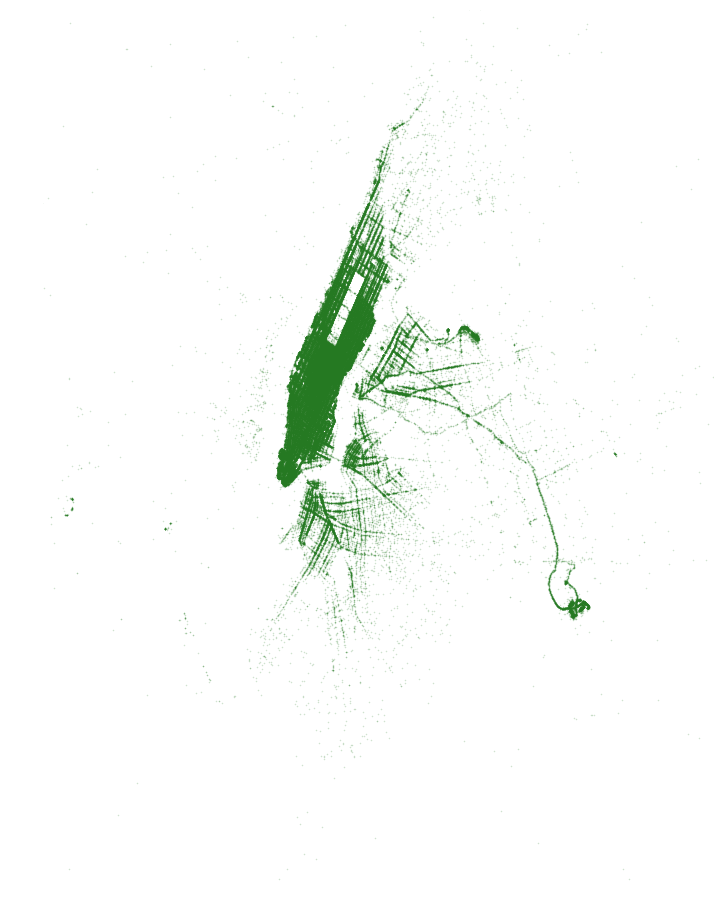

In [11]:
# visualize pickup location
plt.figure(figsize = (12, 16))
plt.scatter(-train['pickup_longitude'].values, train['pickup_latitude'].values, alpha = 1./ 5., s = .3, c = '#22771F')
plt.xlim([-74.2, -73.68])
plt.ylim([40.52, 40.92])
plt.axis('off')
plt.show()

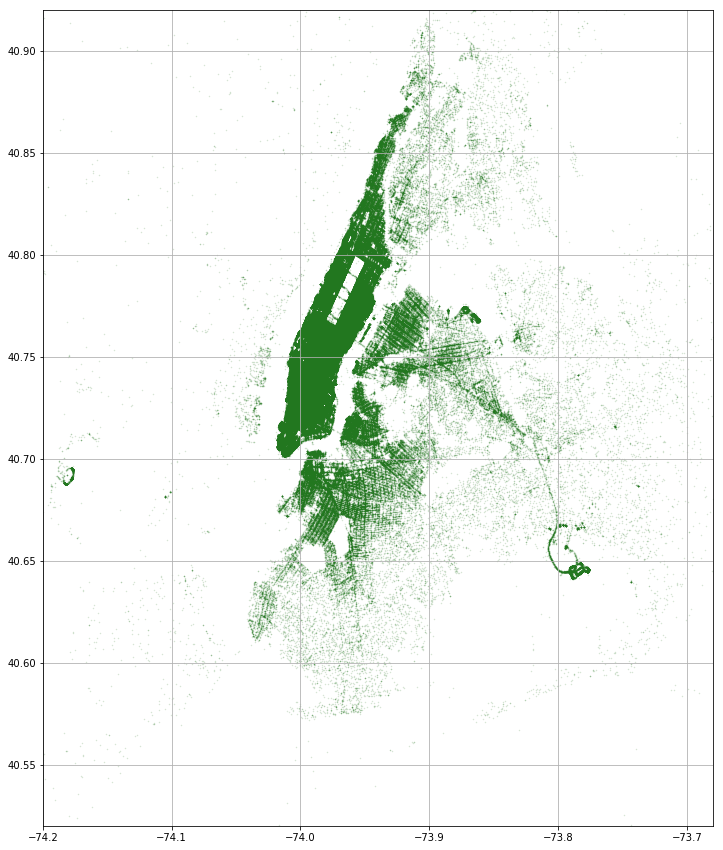

In [12]:
# visualize dropoff location
plt.figure(figsize = (12, 15))
plt.scatter(-train['dropoff_longitude'].values, train['dropoff_latitude'].values, alpha = 1./ 5., s = .2, c = '#22771F')
plt.xlim([-74.2, -73.68])
plt.ylim([40.52, 40.92])
plt.grid()
plt.show()

In [13]:
# extract month, day, hour, weekday
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
train['dropoff_month'] = train['dropoff_datetime'].apply(lambda x: x.month)
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x: x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x: x.hour)
train['dropoff_weekday'] = train['dropoff_datetime'].apply(lambda x: x.weekday() + 1)

for df in all_data:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['pickup_day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['pickup_hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['pickup_weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday() + 1)
    df['pickup_date'] = df['pickup_datetime'].apply(lambda x: x.date())

In [14]:
train.groupby(['pickup_hour', 'dropoff_hour'])[['log_trip_duration']].agg(['mean', 'median', 'count'])

log_trip_duration                  
                                      mean     median  count
pickup_hour dropoff_hour                                    
0           0                     6.311811   6.363028  43192
            1                     6.875128   6.928538  10032
            2                     8.548092   8.555837      9
            11                   14.478062  14.478062      1
            12                   10.725621  10.725621      1
            23                   11.340410  11.349689     13
1           0                    11.329472  11.332686     31
            1                     6.268276   6.322565  31687
            2                     6.800213   6.855409   6757
            3                     8.444298   8.405252     92
            4                     9.182991   9.182991      2
            23                   11.290973  11.290973      2
2           0                    11.254417  11.254951      6
            1                    11.347919  11.346853     20
            2                     6.224366   6.285998  23069
            3                     6.757628   6.820562   4874
            4                     8.664308   8.664308      2
            23                   11.266999  11.266999      1
3           0                    11.209597  11.207119      8
            1                    11.298655  11.298655      1
            2                    11.344655  11.343785      9
            3                     6.205597   6.276643  17104
            4                     6.787298   6.866933   3767
            5                     8.700203   8.656607      5
            15                   10.674406  10.674406      1
4           0                    11.160679  11.158494      4
            1                    11.253662  11.253662      1
            3                    11.345712  11.345619     15
            4                     6.214521   6.304449  13261
            5                     6.867913   6.992096   2506
...                                    ...        ...    ...
19          21                    8.509238   8.463308     26
            22                    9.376194   9.376194      1
20          0                     9.420442   9.418411     11
            1                     9.762097   9.762097      1
            17                   11.263553  11.263553      1
            19                   11.347864  11.348298     18
            20                    6.297350   6.342121  66294
            21                    6.851039   6.881411  17715
            22                    8.541903   8.535230     31
            23                    9.357984   9.357984      1
21          0                     9.115290   9.153876      9
            11                   10.866204  10.866204      1
            19                   11.307192  11.307192      1
            20                   11.344382  11.347981     22
            21                    6.306535   6.349139  65825
            22                    6.863849   6.902743  18302
            23                    8.562581   8.513386     25
22          0                     8.573205   8.495970     45
            15                   14.533144  14.533144      1
            18                   15.075755  15.075755      1
            20                   11.291468  11.291468      1
            21                   11.345333  11.349430     47
            22                    6.339718   6.386879  63209
            23                    6.903523   6.949856  17188
23          0                     6.916727   6.979145  14376
            1                     8.522325   8.474389     16
            2                     9.396903   9.396903      1
            21                   11.297024  11.297024      2
            22                   11.345263  11.350571     24
            23                    6.343491   6.391917  55366

[180 rows x 3 columns]

In [15]:
# create business day variable
bday = pd.bdate_range(pd.to_datetime('2016-01-01'), pd.to_datetime('2016-06-30'))
for df in all_data:
    df['is_bday'] = (df['pickup_datetime'].apply(lambda x: x.date() in bday)).map({True: 1, False: 0})

In [16]:
# extreme weather event
weather_event = ['20160110', '20160113', '20160117', '20160123',
                 '20160205', '20160208', '20160215', '20160216',
                 '20160224', '20160225', '20160314', '20160315',
                 '20160328', '20160329', '20160403', '20160404',
                 '20160530', '20160628']
weather_event = pd.Series(pd.to_datetime(weather_event, format = '%Y%m%d')).dt.date

In [17]:
for df in all_data:
    df['extreme_weather'] = df.pickup_date.isin(weather_event).map({True: 1, False: 0})

In [18]:
# gather airport related trips
def is_jfk(longitude, latitude): 
    return (40.64 < latitude < 40.65) and (-73.79 < longitude < -73.76)
def is_ewr(longitude, latitude):
    return (40.68 < latitude < 40.70) and (-74.18 < longitude < -74.16)
def is_lga(longitude, latitude):
    return (40.77 < latitude < 40.78) and (-73.88 < longitude < -73.86)

In [19]:
is_jfk = np.vectorize(is_jfk)
is_ewr = np.vectorize(is_ewr)
is_lga = np.vectorize(is_lga)

for df in all_data:
    df['is_jfk_pickup'] = is_jfk(-df['pickup_longitude'], df['pickup_latitude']).astype(np.float)
    df['is_ewr_pickup'] = is_ewr(-df['pickup_longitude'], df['pickup_latitude']).astype(np.float)
    df['is_lga_pickup'] = is_lga(-df['pickup_longitude'], df['pickup_latitude']).astype(np.float)
    df['is_jfk_dropoff'] = is_jfk(-df['dropoff_longitude'], df['dropoff_latitude']).astype(np.float)
    df['is_ewr_dropoff'] = is_ewr(-df['dropoff_longitude'], df['dropoff_latitude']).astype(np.float)
    df['is_lga_dropoff'] = is_lga(-df['dropoff_longitude'], df['dropoff_latitude']).astype(np.float)

In [20]:
for df in all_data:
    pickup_hour = pd.get_dummies(df['pickup_hour'], drop_first = True)
    pickup_hour.columns = ['h' + str(i) for i in pickup_hour.columns]
    pickup_hour['h0'] = 0
    df[pickup_hour.columns] = pickup_hour

In [21]:
import seaborn as sns

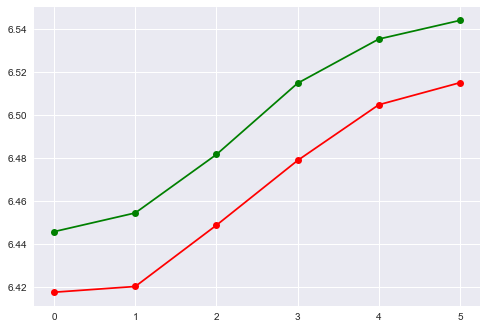

In [22]:
# check the mean and median log-trip_duration by month
duration_by_month = train.groupby('pickup_month')[['log_trip_duration']].agg(['mean', 'median', 'count'])
plt.plot(duration_by_month.loc[:, 'log_trip_duration']['mean'].values,'o-r')
plt.plot(duration_by_month.loc[:, 'log_trip_duration']['median'].values, 'o-g')
plt.show()

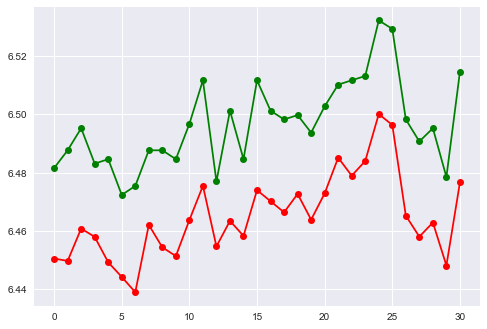

In [23]:
# check the mean and median log-trip_duration by day
duration_by_day = train.groupby('pickup_day')[['log_trip_duration']].agg(['mean', 'median', 'count'])
plt.plot(duration_by_day.loc[:, 'log_trip_duration']['mean'].values, 'o-r')
plt.plot(duration_by_day.loc[:, 'log_trip_duration']['median'].values, 'o-g')
plt.show()

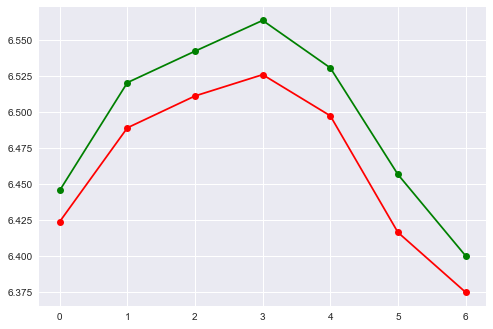

In [24]:
# check the mean and median log-trip_duration by weekday
duration_by_weekday = train.groupby('pickup_weekday')[['log_trip_duration']].agg(['mean', 'median', 'count'])
plt.plot(duration_by_weekday.loc[:, 'log_trip_duration']['mean'].values, 'o-r')
plt.plot(duration_by_weekday.loc[:, 'log_trip_duration']['median'].values, 'o-g')
plt.show()

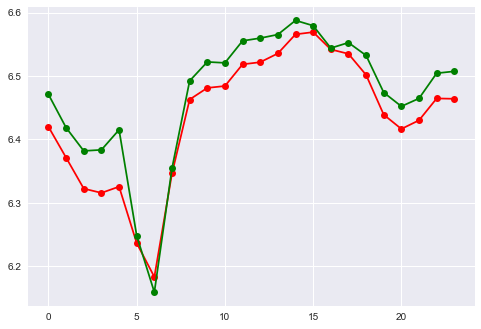

In [25]:
# check the mean and median log-trip_duration by hour
duration_by_hour = train.groupby('pickup_hour')[['log_trip_duration']].agg(['mean', 'median', 'count'])
plt.plot(duration_by_hour.loc[:, 'log_trip_duration']['mean'].values, 'o-r')
plt.plot(duration_by_hour.loc[:, 'log_trip_duration']['median'].values, 'o-g')
plt.show()

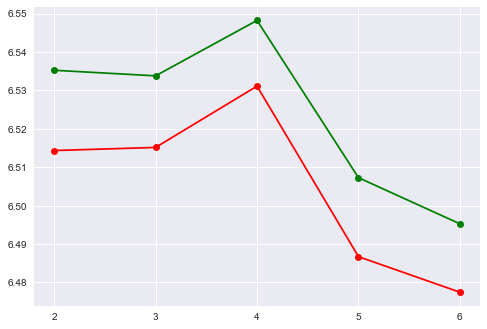

In [26]:
# check the mean and median log-trip_duration by number of passengers
duration_by_passenger = train.groupby('passenger_count')[['log_trip_duration']].agg(['mean', 'median', 'count'])
plt.plot(duration_by_passenger.loc[2:6, 'log_trip_duration']['mean'], 'o-r')
plt.plot(duration_by_passenger.loc[2:6, 'log_trip_duration']['median'], 'o-g')
plt.xticks(np.arange(2, 7))
plt.show()

In [27]:
# create polynomial features
for df in all_data:
    df['pickup_weekdaysq'] = df['pickup_weekday'] ** 2
    df['pickup_daysq'] = df['pickup_day'] ** 2
    df['pickup_daycb'] = df['pickup_day'] ** 3
    df['pickup_dayqd'] = df['pickup_day'] ** 4
    df['passenger_countsq'] = df['passenger_count'] ** 2

In [28]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,direct_distance,...,h20,h21,h22,h23,h0,pickup_weekdaysq,pickup_daysq,pickup_daycb,pickup_dayqd,passenger_countsq
0,id3004672,1,2016-06-30 23:59:58,1,73.988129,40.732029,73.990173,40.756680,N,2.746426,...,0,0,0,1,0,16,900,27000,810000,1
1,id3505355,1,2016-06-30 23:59:53,1,73.964203,40.679993,73.959808,40.655403,N,2.759239,...,0,0,0,1,0,16,900,27000,810000,1
2,id1217141,1,2016-06-30 23:59:47,1,73.997437,40.737583,73.986160,40.729523,N,1.306155,...,0,0,0,1,0,16,900,27000,810000,1
3,id2150126,2,2016-06-30 23:59:41,1,73.956070,40.771900,73.986427,40.730469,N,5.269088,...,0,0,0,1,0,16,900,27000,810000,1
4,id1598245,1,2016-06-30 23:59:33,1,73.970215,40.761475,73.961510,40.755890,N,0.960842,...,0,0,0,1,0,16,900,27000,810000,1


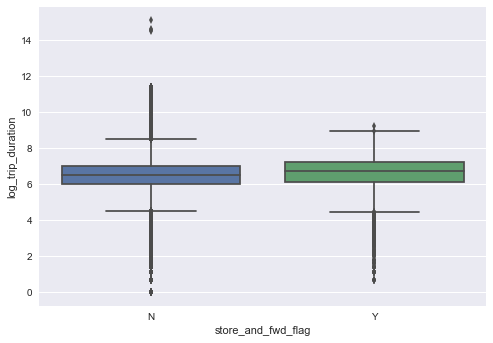

In [29]:
# store_and_fwd_flag N/Y
bplot = sns.boxplot(x = 'store_and_fwd_flag', y = 'log_trip_duration', data = train)
plt.show()

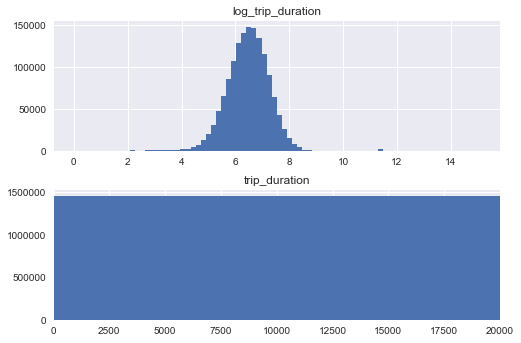

In [30]:
# check the distribution of y, log(y)
trip_hist = train[['trip_duration', 'log_trip_duration']].hist(layout = (2, 1), bins = 80)
trip_hist[1, 0].set_xlim((0, 20000))
plt.show()

In [31]:
train['log_trip_duration'].describe()

count    1.458644e+06
mean     6.464521e+00
std      7.996122e-01
min      0.000000e+00
25%      5.983936e+00
50%      6.495266e+00
75%      6.980076e+00
max      1.507575e+01
Name: log_trip_duration, dtype: float64

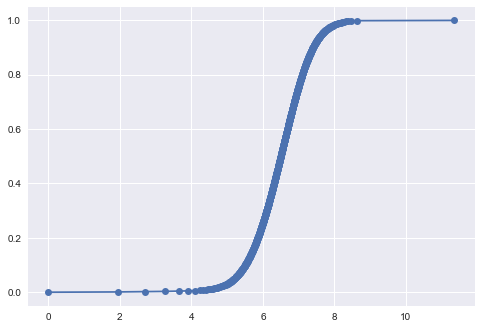

first 5 values: [ 0.          1.94591015  2.7080502   3.25809654  3.63758616]
last 5 values: [  8.39004141   8.46885783   8.62186198  11.35191548  15.07575462]


In [32]:
# check the cumulative distribution of log(y)
quantile_log_trip_duration = train['log_trip_duration'].quantile(np.arange(0, 1.001, .001))
plt.plot(quantile_log_trip_duration.values[:-1], quantile_log_trip_duration.index[:-1], 'o-')
plt.show()
print('first 5 values: {}'.format(quantile_log_trip_duration.head().values))
print('last 5 values: {}'.format(quantile_log_trip_duration.tail().values))

In [33]:
# 6-sigma principle
lower = train['log_trip_duration'].mean() - 3 * train['log_trip_duration'].std()
upper = train['log_trip_duration'].mean() + 3 * train['log_trip_duration'].std()
print('6-sigma range of trip_duration: {}'.format([(np.exp(lower) - 1) / 3600., (np.exp(upper) - 1) / 3600.]))

6-sigma range of trip_duration: [0.015918003255493071, 1.9631044301049505]


In [34]:
# too long / short trip duration might be incorrect
train['abnormal_trip'] = np.logical_or(train.log_trip_duration < 1.945, train.log_trip_duration > 11.35)
train['abnormal_trip'] = train['abnormal_trip'].map({True: 1, False: 0})
train.loc[train['abnormal_trip'] == 1, ['pickup_datetime', 'dropoff_datetime', 'direct_distance', 'trip_duration']].head()

,pickup_datetime,dropoff_datetime,direct_distance,trip_duration
842,2016-05-21 12:46:46,2016-05-21 12:46:49,0.002121,3
1107,2016-06-23 13:36:48,2016-06-23 13:36:50,0.703065,2
1134,2016-05-07 18:36:22,2016-05-08 18:32:11,1.176094,86149
1865,2016-06-07 12:58:48,2016-06-08 12:58:00,4.366104,86352
1960,2016-03-30 08:05:38,2016-03-30 08:05:41,0.001814,3


In [35]:
train.abnormal_trip.value_counts() / train.shape[0]

0    0.998057
1    0.001943
Name: abnormal_trip, dtype: float64

In [36]:
# calculate average speed during the trip
train['avg_speed'] = np.divide(train['direct_distance'], train['trip_duration'] / 3600.)
train['avg_speed'].describe()

count    1.458644e+06
mean     1.442321e+01
std      1.497752e+01
min      0.000000e+00
25%      9.121275e+00
50%      1.279198e+01
75%      1.784491e+01
max      9.274837e+03
Name: avg_speed, dtype: float64

In [37]:
# 6-sigma principle
train['log_avg_speed'] = np.log(train['avg_speed'] + 1)
lower = train['log_avg_speed'].mean() - 3 * train['log_avg_speed'].std()
upper = train['log_avg_speed'].mean() + 3 * train['log_avg_speed'].std()
print('6-sigma range of average speed: {}'.format([np.exp(lower) - 1, np.exp(upper) - 1]))

6-sigma range of average speed: [1.7608224920908464, 65.561026580847169]


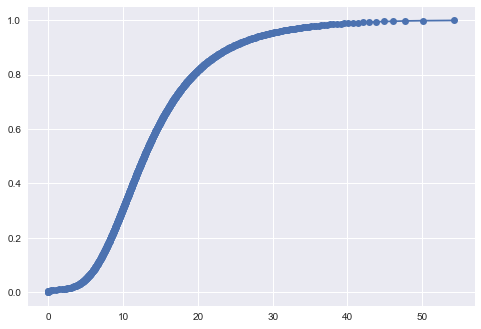

first 5 values: [ 0.  0.  0.  0.  0.]
last 5 values: [   46.15415373    47.74147021    50.0745461     54.30197235  9274.83673124]


In [38]:
quantile_avg_speed = train['avg_speed'].quantile(np.arange(0, 1.001, .001))
plt.plot(quantile_avg_speed.values[:-1], quantile_avg_speed.index[:-1], 'o-')
plt.show()
print('first 5 values: {}'.format(quantile_avg_speed.head().values))
print('last 5 values: {}'.format(quantile_avg_speed.tail().values))

In [39]:
# extremely high speed might be incorrect
train['abnormal_speed'] = train.avg_speed > np.exp(upper) - 1
train['abnormal_speed'] = train['abnormal_speed'].map({True: 1, False: 0})
train.loc[train['abnormal_speed'] == 1, ['pickup_datetime', 'dropoff_datetime', 'direct_distance', 'trip_duration', 'avg_speed', 'abnormal_trip']].head()

,pickup_datetime,dropoff_datetime,direct_distance,trip_duration,avg_speed,abnormal_trip
1107,2016-06-23 13:36:48,2016-06-23 13:36:50,0.703065,2,1265.516683,1
1492,2016-01-13 20:11:46,2016-01-13 20:11:53,0.152765,7,78.564914,0
9561,2016-03-08 23:42:30,2016-03-08 23:42:34,0.089467,4,80.519894,1
12527,2016-05-15 18:31:33,2016-05-15 18:31:59,0.898129,26,124.356287,0
13046,2016-06-27 18:37:21,2016-06-27 18:43:16,15.142631,355,153.559078,0


In [40]:
train.abnormal_speed.value_counts() / train.shape[0]

0    0.999712
1    0.000288
Name: abnormal_speed, dtype: float64

In [41]:
# lower avg_speed might be traffic jam
train['maybe_jam'] = np.logical_and(train.avg_speed < np.exp(lower) - 1, train.log_trip_duration < upper)
train['maybe_jam'] = train['maybe_jam'].map({True: 1, False: 0})
train.loc[train.maybe_jam == 1, ['pickup_datetime', 'dropoff_datetime', 
                                 'pickup_longitude', 'pickup_latitude',
                                 'dropoff_longitude', 'dropoff_latitude',
                                 'direct_distance', 'trip_duration', 'avg_speed', 'abnormal_trip']].head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,direct_distance,trip_duration,avg_speed,abnormal_trip
323,2016-06-27 11:22:37,2016-06-27 11:23:17,74.001030,40.756653,74.000999,40.756626,0.003927,40,0.353456,0
1182,2016-05-19 07:20:41,2016-05-19 07:21:22,73.992729,40.737503,73.992737,40.737450,0.005973,41,0.524471,0
1334,2016-05-28 06:15:14,2016-05-28 06:15:54,73.984039,40.746639,73.984070,40.746628,0.002869,40,0.258170,0
1620,2016-01-27 22:29:31,2016-01-27 22:29:58,74.209854,40.816853,74.209854,40.816853,0.000000,27,0.000000,0
1728,2016-01-22 16:13:01,2016-01-22 16:13:20,73.776314,40.645454,73.776314,40.645454,0.000000,19,0.000000,0


In [42]:
# set abnormal observations
train['abnormal'] = train['abnormal_trip'] + train['abnormal_speed']

In [43]:
# add neighbors info
# from https://www.kaggle.com/c/nyc-taxi-trip-duration/discussion/38220
train_neighbors = pd.read_csv('C:/Users/bangda/desktop/kaggle/ny-taxi/external-data/train_neighbors.csv')
test_neighbors  = pd.read_csv('C:/Users/bangda/desktop/kaggle/ny-taxi/external-data/test_neighbors.csv')
train = pd.concat([all_data[0], train_neighbors], axis = 'columns')
test  = pd.concat([all_data[1], test_neighbors], axis = 'columns')
all_data = [train, test]

In [44]:
train.iloc[:, -8:].head()

,pickup_boro,pickup_boro_code,pickup_neighborhood_name,pickup_neighborhood_code,dropoff_boro,dropoff_boro_code,dropoff_neighborhood_name,dropoff_neighborhood_code
0,Manhattan,1.0,Lincoln Square,MN14,Manhattan,1.0,Upper East Side-Carnegie Hill,MN40
1,Manhattan,1.0,Murray Hill-Kips Bay,MN20,Manhattan,1.0,West Village,MN23
2,Manhattan,1.0,Midtown-Midtown South,MN17,Manhattan,1.0,Battery Park City-Lower Manhattan,MN25
3,Manhattan,1.0,SoHo-TriBeCa-Civic Center-Little Italy,MN24,Manhattan,1.0,Battery Park City-Lower Manhattan,MN25
4,Manhattan,1.0,Upper West Side,MN12,Manhattan,1.0,Upper West Side,MN12


In [45]:
train.pickup_boro.value_counts()

Manhattan        1343789
Queens             85922
Brooklyn           26394
Bronx               1257
Staten Island         57
Name: pickup_boro, dtype: int64

In [46]:
train.pickup_boro_code.value_counts()

1.0    1343789
4.0      85922
3.0      26394
2.0       1257
5.0         57
Name: pickup_boro_code, dtype: int64

In [47]:
train.pickup_boro.isnull().sum(), train.dropoff_boro.isnull().sum(), test.pickup_boro.isnull().sum(), test.dropoff_boro.isnull().sum()

(1225, 6335, 529, 2642)

In [48]:
train.pickup_neighborhood_code.value_counts().shape, train.dropoff_neighborhood_code.value_counts().shape, test.pickup_neighborhood_code.value_counts().shape, test.dropoff_neighborhood_code.value_counts().shape

((188L,), (194L,), (179L,), (193L,))

In [49]:
train.pickup_neighborhood_code.isnull().sum(), test.pickup_neighborhood_code.isnull().sum()

(1225, 529)

In [50]:
# fill missing data (trip out of NYC)
for df in all_data:
    df['pickup_boro_code'].fillna(value = 6., inplace = True)
    df['dropoff_boro_code'].fillna(value = 6., inplace = True)
    df['pickup_neighborhood_code'].fillna(value = 'out_ny', inplace = True)
    df['dropoff_neighborhood_code'].fillna(value = 'out_ny', inplace = True)

In [51]:
for df in all_data:
    df.drop(['pickup_boro', 'dropoff_boro', 'pickup_neighborhood_name', 'dropoff_neighborhood_name'], inplace = True, axis = 'columns')

In [52]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,abnormal_trip,avg_speed,log_avg_speed,abnormal_speed,maybe_jam,abnormal,pickup_boro_code,pickup_neighborhood_code,dropoff_boro_code,dropoff_neighborhood_code
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,73.982155,40.767937,73.964630,40.765602,N,...,0,11.856428,2.553844,0,0,0,1.0,MN14,1.0,MN40
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,73.980415,40.738564,73.999481,40.731152,N,...,0,9.803659,2.379885,0,0,0,1.0,MN20,1.0,MN23
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,73.979027,40.763939,74.005333,40.710087,N,...,0,10.822201,2.469979,0,0,0,1.0,MN17,1.0,MN25
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,74.010040,40.719971,74.012268,40.706718,N,...,0,12.465721,2.600147,0,0,0,1.0,MN24,1.0,MN25
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,73.973053,40.793209,73.972923,40.782520,N,...,0,9.836594,2.382929,0,0,0,1.0,MN12,1.0,MN12


In [53]:
# create dummy variable for hour
for df in all_data:
    pickup_hour = pd.get_dummies(df['pickup_hour'], drop_first = True)
    pickup_hour.columns = ['h' + str(i) for i in pickup_hour.columns]
    pickup_hour['h0'] = 0
    df[pickup_hour.columns] = pickup_hour

In [54]:
# create dummy variable for neighbors
for df in all_data:
    pickup_boro_code = pd.get_dummies(df['pickup_boro_code'], drop_first = True)
    pickup_boro_code.columns = ['pn' + str(i) for i in pickup_boro_code.columns]
    pickup_boro_code['pn1'] = 0
    df[pickup_boro_code.columns] = pickup_boro_code
    dropoff_boro_code = pd.get_dummies(df['dropoff_boro_code'], drop_first = True)
    dropoff_boro_code.columns = ['dn' + str(i) for i in dropoff_boro_code.columns]
    dropoff_boro_code['dn1'] = 0
    df[dropoff_boro_code.columns] = dropoff_boro_code    

In [55]:
all_pickup_neighborhood_code = np.union1d(train.pickup_neighborhood_code.values, test.pickup_neighborhood_code.values)
all_dropoff_neighborhood_code = np.union1d(train.pickup_neighborhood_code.values, test.pickup_neighborhood_code.values)
np.union1d(all_pickup_neighborhood_code, all_dropoff_neighborhood_code)

array(['BK09', 'BK17', 'BK19', 'BK21', 'BK23', 'BK25', 'BK26', 'BK27',
       'BK28', 'BK29', 'BK30', 'BK31', 'BK32', 'BK33', 'BK34', 'BK35',
       'BK37', 'BK38', 'BK40', 'BK41', 'BK42', 'BK43', 'BK44', 'BK45',
       'BK46', 'BK50', 'BK58', 'BK60', 'BK61', 'BK63', 'BK64', 'BK68',
       'BK69', 'BK72', 'BK73', 'BK75', 'BK76', 'BK77', 'BK78', 'BK79',
       'BK81', 'BK82', 'BK83', 'BK85', 'BK88', 'BK90', 'BK91', 'BK93',
       'BK95', 'BK96', 'BK99', 'BX01', 'BX03', 'BX05', 'BX06', 'BX07',
       'BX08', 'BX09', 'BX10', 'BX13', 'BX14', 'BX17', 'BX22', 'BX26',
       'BX27', 'BX28', 'BX29', 'BX30', 'BX31', 'BX33', 'BX34', 'BX35',
       'BX36', 'BX37', 'BX39', 'BX40', 'BX41', 'BX43', 'BX44', 'BX46',
       'BX49', 'BX52', 'BX55', 'BX59', 'BX62', 'BX63', 'BX75', 'BX98',
       'BX99', 'MN01', 'MN03', 'MN04', 'MN06', 'MN09', 'MN11', 'MN12',
       'MN13', 'MN14', 'MN15', 'MN17', 'MN19', 'MN20', 'MN21', 'MN22',
       'MN23', 'MN24', 'MN25', 'MN27', 'MN28', 'MN31', 'MN32', 'MN33',
      

In [56]:
train_test = train.loc[:, ['pickup_neighborhood_code', 'dropoff_neighborhood_code']].append(test.loc[:, ['pickup_neighborhood_code', 'dropoff_neighborhood_code']])
train_test_pickup_neighborhood_code = pd.get_dummies(train_test['pickup_neighborhood_code'])
train_test_dropoff_neighborhood_code = pd.get_dummies(train_test['dropoff_neighborhood_code'])

In [57]:
# split into train and test
train[train_test_pickup_neighborhood_code.columns] = train_test_pickup_neighborhood_code.iloc[:1458644]
test[train_test_pickup_neighborhood_code.columns] = train_test_pickup_neighborhood_code.iloc[1458644:]

In [58]:
train[train_test_dropoff_neighborhood_code.columns] = train_test_dropoff_neighborhood_code.iloc[:1458644]
test[train_test_dropoff_neighborhood_code.columns] = train_test_dropoff_neighborhood_code.iloc[1458644:]

In [59]:
del train_test_pickup_neighborhood_code, train_test_dropoff_neighborhood_code, train_neighbors, test_neighbors, train_test

In [60]:
train.shape, test.shape

((1458644, 276), (625134, 263))

In [61]:
# add weather info
# from
weather = pd.read_csv('C:/Users/bangda/desktop/kaggle/ny-taxi/external-data/Weather.csv', index_col = 0)
weather = weather.loc['2016-01-01':'2016-07-01']
weather.tail()

,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,wdird,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-30 19:51:00,25.6,78.1,15.6,60.1,54.0,9.3,5.8,NaN,NaN,0,...,NaN,NaN,Partly Cloudy,partlycloudy,0,0,0,0,0,0
2016-06-30 20:51:00,25.0,77.0,16.1,61.0,58.0,5.6,3.5,NaN,NaN,0,...,NaN,NaN,Clear,clear,0,0,0,0,0,0
2016-06-30 21:51:00,24.4,75.9,16.1,61.0,60.0,0.0,0.0,NaN,NaN,0,...,NaN,NaN,Clear,clear,0,0,0,0,0,0
2016-06-30 22:51:00,24.4,75.9,16.1,61.0,60.0,7.4,4.6,NaN,NaN,190,...,NaN,NaN,Clear,clear,0,0,0,0,0,0
2016-06-30 23:51:00,24.4,75.9,15.6,60.1,58.0,5.6,3.5,NaN,NaN,0,...,NaN,NaN,Clear,clear,0,0,0,0,0,0


In [62]:
weather['pickup_date'] = pd.to_datetime(weather.index)
weather['date'] = weather['pickup_date'].dt.strftime('%Y%m%d')
weather['hour'] = weather['pickup_date'].dt.strftime('%H')
weather['date_hour'] = weather['date'] + weather['hour']
weather = weather.reset_index()

In [63]:
weather.head()

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,fog,rain,snow,hail,thunder,tornado,pickup_date,date,hour,date_hour
0,2016-01-01 00:51:00,5.6,42.1,-3.9,25.0,51.0,7.4,4.6,NaN,NaN,...,0,0,0,0,0,0,2016-01-01 00:51:00,20160101,00,2016010100
1,2016-01-01 01:51:00,5.0,41.0,-3.9,25.0,53.0,5.6,3.5,NaN,NaN,...,0,0,0,0,0,0,2016-01-01 01:51:00,20160101,01,2016010101
2,2016-01-01 02:51:00,5.0,41.0,-3.3,26.1,55.0,7.4,4.6,NaN,NaN,...,0,0,0,0,0,0,2016-01-01 02:51:00,20160101,02,2016010102
3,2016-01-01 03:51:00,5.0,41.0,-3.3,26.1,55.0,14.8,9.2,NaN,NaN,...,0,0,0,0,0,0,2016-01-01 03:51:00,20160101,03,2016010103
4,2016-01-01 04:51:00,4.4,39.9,-3.3,26.1,58.0,16.7,10.4,25.9,16.1,...,0,0,0,0,0,0,2016-01-01 04:51:00,20160101,04,2016010104


In [64]:
weather = weather[['date_hour', 'tempi', 'hum', 'wspdi', 'precipm']]

In [65]:
# create match id
for df in all_data:
    df['date_hour'] = df['pickup_datetime'].dt.strftime('%Y%m%d') + df['pickup_datetime'].dt.strftime('%H')

In [66]:
# join tables
train = train.join(weather, on = 'date_hour', how = 'left', lsuffix = '_train', rsuffix = '_weather')
test  = test.join(weather, on = 'date_hour', how = 'left', lsuffix = '_test', rsuffix = '_weather')

In [67]:
del weather
all_data = [train, test]
for df in all_data:
    df['precipm'].fillna(0.0, inplace = True)
    df['wspdi'].fillna(0.0, inplace = True)
    df['hum'].fillna(0.0, inplace = True)
    df['tempi'].fillna(0.0, inplace = True)

In [68]:
train.columns.values

array(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'direct_distance',
       'dropoff_month', 'dropoff_day', 'dropoff_hour', 'dropoff_weekday',
       'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday',
       'pickup_date', 'is_bday', 'extreme_weather', 'is_jfk_pickup',
       'is_ewr_pickup', 'is_lga_pickup', 'is_jfk_dropoff',
       'is_ewr_dropoff', 'is_lga_dropoff', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h0',
       'pickup_weekdaysq', 'pickup_daysq', 'pickup_daycb', 'pickup_dayqd',
       'passenger_countsq', 'abnormal_trip', 'avg_speed', 'log_avg_speed',
       'abnormal_speed', 'maybe_jam', 'abnormal', 'pickup_boro_code',
       'pickup_neighborhood_c

In [69]:
del train['date_hour_train']
del test['date_hour_test']

for df in all_data:
    del df['date_hour_weather']

In [70]:
# gather and drop some variables
for df in all_data:
    del df['pickup_boro_code']
    del df['pickup_neighborhood_code']
    del df['dropoff_boro_code']
    del df['dropoff_neighborhood_code']
    df['jfk_trip'] = df['is_jfk_pickup'] + df['is_jfk_dropoff']
    del df['is_jfk_pickup']
    del df['is_jfk_dropoff']
    df['ewr_trip'] = df['is_ewr_pickup'] + df['is_ewr_dropoff']
    del df['is_ewr_pickup']
    del df['is_ewr_dropoff']
    df['lga_trip'] = df['is_lga_pickup'] + df['is_lga_dropoff']
    del df['is_lga_pickup']
    del df['is_lga_dropoff']
    del df['is_bday']
    df['pickup_weekdaycb'] = df['pickup_weekday'] ** 3
    df['passenger_countcb'] = df['passenger_count'] ** 3
    df['out_ny'] = 0

In [71]:
del train['dropoff_month']
del train['dropoff_day']
del train['dropoff_hour']
del train['dropoff_weekday']

In [72]:
test.columns.values

array(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'direct_distance',
       'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday',
       'pickup_date', 'extreme_weather', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h0',
       'pickup_weekdaysq', 'pickup_daysq', 'pickup_daycb', 'pickup_dayqd',
       'passenger_countsq', 'pn2.0', 'pn3.0', 'pn4.0', 'pn5.0', 'pn6.0',
       'pn1', 'dn2.0', 'dn3.0', 'dn4.0', 'dn5.0', 'dn6.0', 'dn1', 'BK09',
       'BK17', 'BK19', 'BK21', 'BK23', 'BK25', 'BK26', 'BK27', 'BK28',
       'BK29', 'BK30', 'BK31', 'BK32', 'BK33', 'BK34', 'BK35', 'BK37',
       'BK38', 'BK40', 'BK41', 'BK42', 'BK43', 'BK44', 'BK45', 'BK46',
       'BK50', 'BK58', 'BK60', 'BK61', 'BK63', 'BK64', 'BK68', 'BK69',
       'BK72

In [73]:
train.shape, test.shape

((1458644, 270), (625134, 261))

In [74]:
predictors = [
       'passenger_count', 
       'direct_distance',
       'pickup_month', 'pickup_day', 'pickup_weekday',
       'extreme_weather', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15',
       'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h0',
       'pickup_weekdaysq', 'pickup_daysq', 'pickup_daycb', 'pickup_dayqd',
       'passenger_countsq', 
       'pn2.0', 'pn3.0',
       'pn4.0', 'pn5.0', 'pn6.0', 'pn1', 'dn2.0', 'dn3.0', 'dn4.0',
       'dn5.0', 'dn6.0', 'dn1', 'BK09', 'BK17', 'BK19', 'BK21', 'BK23',
       'BK25', 'BK26', 'BK27', 'BK28', 'BK29', 'BK30', 'BK31', 'BK32',
       'BK33', 'BK34', 'BK35', 'BK37', 'BK38', 'BK40', 'BK41', 'BK42',
       'BK43', 'BK44', 'BK45', 'BK46', 'BK50', 'BK58', 'BK60', 'BK61',
       'BK63', 'BK64', 'BK68', 'BK69', 'BK72', 'BK73', 'BK75', 'BK76',
       'BK77', 'BK78', 'BK79', 'BK81', 'BK82', 'BK83', 'BK85', 'BK88',
       'BK90', 'BK91', 'BK93', 'BK95', 'BK96', 'BK99', 'BX01', 'BX03',
       'BX05', 'BX06', 'BX07', 'BX08', 'BX09', 'BX10', 'BX13', 'BX14',
       'BX17', 'BX22', 'BX26', 'BX27', 'BX28', 'BX29', 'BX30', 'BX31',
       'BX33', 'BX34', 'BX35', 'BX36', 'BX37', 'BX39', 'BX40', 'BX41',
       'BX43', 'BX44', 'BX46', 'BX49', 'BX52', 'BX55', 'BX59', 'BX62',
       'BX63', 'BX75', 'BX98', 'BX99', 'MN01', 'MN03', 'MN04', 'MN06',
       'MN09', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN17', 'MN19',
       'MN20', 'MN21', 'MN22', 'MN23', 'MN24', 'MN25', 'MN27', 'MN28',
       'MN31', 'MN32', 'MN33', 'MN34', 'MN35', 'MN36', 'MN40', 'MN50',
       'MN99', 'QN01', 'QN02', 'QN03', 'QN05', 'QN06', 'QN07', 'QN08',
       'QN10', 'QN12', 'QN15', 'QN17', 'QN18', 'QN19', 'QN20', 'QN21',
       'QN22', 'QN23', 'QN25', 'QN26', 'QN27', 'QN28', 'QN29', 'QN30',
       'QN31', 'QN33', 'QN34', 'QN35', 'QN37', 'QN38', 'QN41', 'QN42',
       'QN43', 'QN44', 'QN45', 'QN46', 'QN47', 'QN48', 'QN49', 'QN50',
       'QN51', 'QN52', 'QN53', 'QN54', 'QN55', 'QN56', 'QN57', 'QN60',
       'QN61', 'QN62', 'QN63', 'QN66', 'QN68', 'QN70', 'QN71', 'QN72',
       'QN76', 'QN98', 'QN99', 'SI01', 'SI05', 'SI07', 'SI08', 'SI12',
       'SI14', 'SI22', 'SI25', 'SI28', 'SI32', 'SI35', 'SI36', 'SI37',
       'SI54', 'out_ny', 'SI11', 'SI24', 'SI45', 'SI48', 'tempi', 'hum',
       'wspdi', 'precipm', 'jfk_trip', 'ewr_trip', 'lga_trip',
       'pickup_weekdaycb', 'passenger_countcb']

In [75]:
len(predictors)

251

In [76]:
train.to_csv('train_featured.csv', index = False)
test.to_csv('test_featured.csv', index = False)

In [77]:
import gc
gc.collect()

188